In [1]:
import numpy as np
import pandas as pd
import os.path

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
dataZip = '../Input/Program.zip'
folder_path = '../Input/Program'

In [3]:
import sys
sys.path.insert(1, r'./../Python')
from helper import *

In [4]:
def file_checking(folder, zipFile):
    """
    This function takes in a folder path and a zipfile.
    If the folder exists, it does nothing with the zipfile
    it will then return a list of the files within
    
    Otherwise, it will unzip the zipfile and return a list
    of the files within the zipfile
    """
    files = []
    if (os.path.isdir(folder)): # Check that the directory exists
        files = os.listdir(folder)
        
    elif (os.path.isfile(zipFile)): # If directory doesn't exist, check that a zipfile exists
        import zipfile
        with zipfile.ZipFile(zipFile, 'r') as zip_ref:
            zip_ref.extractall(folder)

        files = os.listdir(folder)
        
    else:
        print("Folder does not exist, nor does zipfile")
    
    for i in range(len(files)):
        files[i] = folder + '/' + files[i]
    
    files.sort()
    
    return files

In [5]:
prog_files = file_checking(folder_path, dataZip)

In [6]:
prog_files

['../Input/Program/Prog1.txt',
 '../Input/Program/Prog2.txt',
 '../Input/Program/Prog3.txt',
 '../Input/Program/prog4.txt',
 '../Input/Program/prog5.txt',
 '../Input/Program/prog6.txt',
 '../Input/Program/prog7.txt',
 '../Input/Program/prog8.txt']

In [7]:
textResults = '../Results/Text'

if not os.path.exists(textResults): # There is a race condition here.
    os.makedirs(textResults)        # Make sure you don't create a folder while running this

else:
    pass

In [8]:
def parse(input_file, avoid = ["top", "Tasks", "%Cpu(s)", "KiB Mem", "KiB Swap"]):
    
    PIDCPU = {}
    PIDMEM = {}
    
    pid_key = {}
    
    # if not os.path.isfile(newfile):
    with open(input_file) as f:
        for line in f:
            if not any(line.startswith(no) for no in avoid): # This removes the info at start of top
                if not line.isspace(): # Removes empty lines
                    new_line = line.lstrip(' ') # Some lines start with empty spaces
                    sections = new_line.split()
                    PID, CPU, MEM, name = sections[0], sections[8], sections[9], sections[11]
                    if PID == 'PID':
                        pass
                    
                    elif PID not in PIDCPU or PID not in PIDMEM:
                        PIDCPU[PID] = list()
                        PIDCPU[PID].append(float(CPU))
                        
                        PIDMEM[PID] = list()
                        PIDMEM[PID].append(float(MEM))
                        pid_key[PID] = name
                        
                    else:
                        PIDCPU[PID].append(float(CPU))
                        PIDMEM[PID].append(float(MEM))
    
    return PIDCPU, PIDMEM, pid_key

In [9]:
cpu, mem, pid = parse(prog_files[0])

In [10]:
def create_dataframe(cpu_dict, mem_dict, key, time_interval = 0.5):
    '''
    cpu_dict: a Dictionary of lists
    mem_dict: a Dictionary of lists
    
    key = the above two dicts are using PID values as keys.
    Not intuitive for understanding what they mean.
    
    Returns two dataframes, one for cpu and one for mem
    '''
    
    # Turn dicts into Dataframes
    cpu_frame = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in cpu_dict.items() ]))
    mem_frame = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in mem_dict.items() ]))
    
    # Here I am removing every column that has a mean of 0
    cpu_frame = cpu_frame.drop(cpu_frame.columns[cpu_frame.apply(lambda col: col.mean() == 0)], axis=1)
    mem_frame = mem_frame.drop(mem_frame.columns[mem_frame.apply(lambda col: col.mean() == 0)], axis=1)

    # Here I remove every instance of N/A with a 0
    cpu_frame = cpu_frame.fillna(0)
    mem_frame = mem_frame.fillna(0)
    
    # I rename the columns by the their command name. Before they were PID
    cpu_frame.rename(columns = key, inplace = True)
    mem_frame.rename(columns = key, inplace = True)
    
    # I remove duplicate columns here
    cpu_frame = cpu_frame.groupby(cpu_frame.columns, axis=1).sum()
    mem_frame = mem_frame.groupby(mem_frame.columns, axis=1).sum()
    
    # Adding a time index
    df_len = len(cpu_frame)
    cpu_frame['time'] = pd.Series([x * time_interval for x in range(df_len)])
    cpu_frame.set_index('time')
    
    df_len2 = len(mem_frame)
    mem_frame['time'] = pd.Series([x * time_interval for x in range(df_len2)])
    mem_frame.set_index('time')
    
    return cpu_frame, mem_frame

In [11]:
cpu_frame, mem_frame = create_dataframe(cpu, mem, pid)

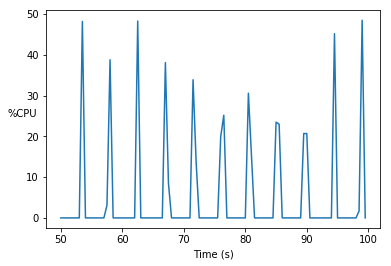

In [12]:
plt.plot(cpu_frame['time'][100:200], cpu_frame['main'][100:200])
plt.xlabel('Time (s)')
plt.ylabel('%CPU', rotation = 0)
plt.show()